In [ ]:
#Colab_libraries
#!pip install segmentation-models-pytorch
#!pip install patchify
#!pip install keras==3.2.0

In [2]:
import tensorflow as tf
import segmentation_models_pytorch as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras
from keras.models import load_model
import numpy as np
from patchify import patchify
import tifffile as tiff
import sys
sys.setrecursionlimit(1500)

In [ ]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=2 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/drive/MyDrive/patches/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 1)
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

#Convert list to array for machine learning processing
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("/content/drive/MyDrive/patches/masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

#Convert list to array for machine learning processing
train_masks = np.array(train_masks)



#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
#ok



np.unique(train_masks_encoded_original_shape)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

n_classes=2
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


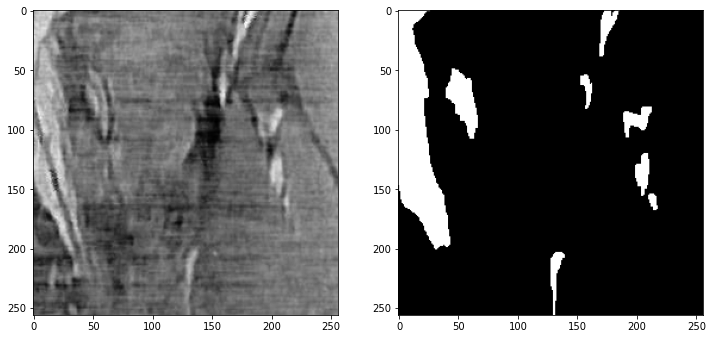

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:

#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.


In [ ]:

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

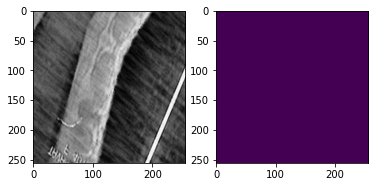

In [ ]:

x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()



In [ ]:
X_train.shape


(93, 256, 256, 3)

In [ ]:
y_test_cat.shape

(21, 256, 256, 2)

In [ ]:
import time

In [ ]:
########################################################################
###Model 1
BACKBONE1 = 'vgg16'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())

history1=model1.fit(X_train1,
          y_train_cat,
          batch_size=8,
          epochs=100,
          verbose=1,
          validation_data=(X_test1, y_test_cat))




58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                             

In [ ]:
t0 = time.time()
print("Training time:", time.time()-t0)

In [ ]:
model1.save('/content/drive/MyDrive/patches/vgg16.h5')

In [ ]:
_, acc = model1.evaluate(X_test1, y_test_cat)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 7s 7s/step - loss: 0.4143 - iou_score: 0.6350
Accuracy =  63.49817514419556 %


In [ ]:
y_pred=model1.predict(X_test1)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test_cat, y_pred_thresholded)
union = np.logical_or(y_test_cat, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 0s 70ms/step
IoU socre is:  0.9780670865444594


In [ ]:
BACKBONE4 = 'resnet50'
preprocess_input4 = sm.get_preprocessing(BACKBONE4)

# preprocess input
X_train4 = preprocess_input4(X_train)
X_test4 = preprocess_input4(X_test)

# define model
model4 = sm.Unet(BACKBONE4, encoder_weights='imagenet', classes=n_classes, activation=activation)


# compile keras model with defined optimozer, loss and metrics
model4.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model4.summary())


history4=model4.fit(X_train4,
          y_train_cat,
          batch_size=8,
          epochs=100,
          verbose=1,
          validation_data=(X_test4, y_test_cat))




94592056/94592056 [==============================] - 1s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                       

In [ ]:
t0 = time.time()
print("Training time:", time.time()-t0)

In [ ]:
BACKBONE3 = 'resnet34'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)

# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)


# compile keras model with defined optimozer, loss and metrics
model3.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model3.summary())


history3=model3.fit(X_train3,
          y_train_cat,
          batch_size=8,
          epochs=100,
          verbose=1,
          validation_data=(X_test3, y_test_cat))




Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_52 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [ ]:
t0 = time.time()
print("Training time:", time.time()-t0)

Training time: 5.793571472167969e-05


In [ ]:
y_pred=model3.predict(X_test3)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test_cat, y_pred_thresholded)
union = np.logical_or(y_test_cat, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 3s 3s/step
IoU socre is:  0.9853291845363547


In [ ]:
y_pred=model4.predict(X_test4)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test_cat, y_pred_thresholded)
union = np.logical_or(y_test_cat, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 3s 3s/step
IoU socre is:  0.983296429649666


In [ ]:
model4.save('/content/drive/MyDrive/patches/resnet50.h5')


In [ ]:
BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)


# compile keras model with defined optimozer, loss and metrics
model2.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model2.summary())


history2=model2.fit(X_train2,
          y_train_cat,
          batch_size=8,
          epochs=100,
          verbose=1,
          validation_data=(X_test2, y_test_cat))


model2.save('/content/drive/MyDrive/patches/inceptionv3.h5')

87910968/87910968 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                

In [ ]:
t0 = time.time()
print("Training time:", time.time()-t0)

Training time: 3.5762786865234375e-05


In [ ]:
BACKBONE5 = 'densenet121'
preprocess_input2 = sm.get_preprocessing(BACKBONE5)

# preprocess input
X_train5 = preprocess_input2(X_train)
X_test5 = preprocess_input2(X_test)

# define model
model5 = sm.Unet(BACKBONE5, encoder_weights='imagenet', classes=n_classes, activation=activation)


# compile keras model with defined optimozer, loss and metrics
model5.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model5.summary())


history2=model5.fit(X_train5,
          y_train_cat,
          batch_size=8,
          epochs=100,
          verbose=1,
          validation_data=(X_test5, y_test_cat))


model5.save('/content/drive/MyDrive/patches/densenet121.h5')

29084464/29084464 [==============================] - 2s 0us/step
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_104 (ZeroPaddin  (None, None, None,   0          ['input_3[0][0]']                
 g2D)                           3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_104[0][0]']     
                          

In [ ]:
y_pred=model3.predict(X_test3)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test_cat, y_pred_thresholded)
union = np.logical_or(y_test_cat, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 1s 1s/step
IoU socre is:  0.7934828927563806


In [ ]:
y_pred=model2.predict(X_test2)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test_cat, y_pred_thresholded)
union = np.logical_or(y_test_cat, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 5s 5s/step
IoU socre is:  0.9841699609871716


1/1 [==============================] - 0s 19ms/step


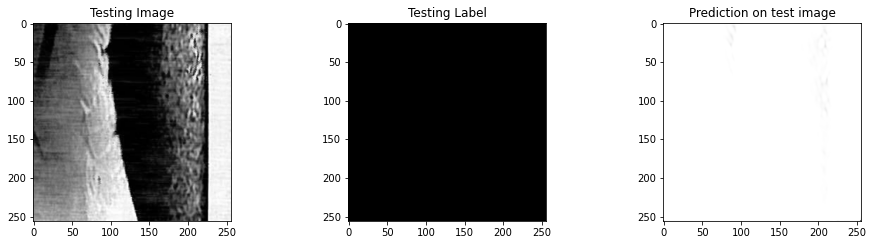

In [ ]:
test_img_number = random.randint(0, len(X_test3)-1)
test_img = X_test3[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model3.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray') #JET

plt.show()

1/1 [==============================] - 0s 270ms/step - loss: 0.4143 - iou_score: 0.6350
Test accuracy: 0.6349817514419556


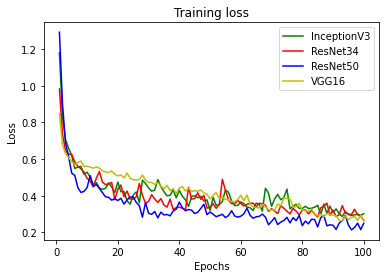

In [ ]:
loss4 = history4.history['loss']
#val_loss = history4.history['val_loss']
epochs = range(1, len(loss4) + 1)
plt.plot(epochs, loss4, 'y',color='g',label='InceptionV3')

loss3 = history3.history['loss']
#val_loss = history3.history['val_loss']
epochs = range(1, len(loss3) + 1)
plt.plot(epochs, loss3,'y',color='r', label='ResNet34')

loss2 = history2.history['loss']
#val_loss = history2.history['val_loss']
epochs = range(1, len(loss2) + 1)
plt.plot(epochs, loss2, 'y',color='b',label='ResNet50')

loss1 = history1.history['loss']
#val_loss = history2.history['val_loss']
epochs = range(1, len(loss1) + 1)
plt.plot(epochs, loss1, 'y',label='VGG16')

#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/patches/As.jpg', dpi=900)

plt.show()









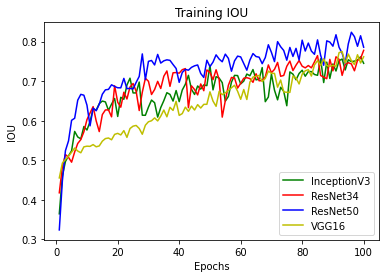

In [ ]:
acc = history4.history['iou_score']
#val_acc = history4.history['val_iou_score']
plt.plot(epochs, acc, 'y', color='g', label='InceptionV3')
#plt.plot(epochs, val_acc, 'r', label='Validation IOU')

acc = history3.history['iou_score']
#val_acc = history3.history['val_iou_score']
plt.plot(epochs, acc, 'y',color='r', label='ResNet34')
#plt.plot(epochs, val_acc, 'r', label='Validation IOU')

acc = history2.history['iou_score']
#val_acc = history2.history['val_iou_score']
plt.plot(epochs, acc, 'y',color='b', label='ResNet50')
#plt.plot(epochs, val_acc, 'r', label='Validation IOU')

acc = history1.history['iou_score']
#val_acc = history1.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='VGG16')
#plt.plot(epochs, val_acc, 'r', label='Validation IOU')



plt.title('Training IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig('/content/drive/MyDrive/patches/IOU.jpg', dpi=900)
plt.show()

In [ ]:
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/drive/MyDrive/patches/images/image_18_11.tif', cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
#test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)
prediction = model1.predict(test_img)
prediction_image = prediction.reshape(mask.shape)

In [ ]:
test_img.shape


(1, 256, 256, 3)

In [ ]:
plt.imshow(prediction, cmap='gray')


In [ ]:
#model1_VGG15  63.49
#model2_InceptionV3  59.82
#model3_resnet34  66.74
#model4_resnet50 66.07
#model5_densnet


In [ ]:
_, acc = model4.evaluate(X_test4, y_test_cat)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 0s 222ms/step - loss: 0.3843 - iou_score: 0.6607
Accuracy =  66.07253551483154 %


In [ ]:
_, acc = model4.evaluate(X_test4, y_test_cat)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 1s 1s/step - loss: 0.3843 - iou_score: 0.6607
Accuracy =  66.07253551483154 %


In [ ]:
y_pred=model2.predict(X_test2)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test_cat, y_pred_thresholded)
union = np.logical_or(y_test_cat, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 1s 1s/step
IoU socre is:  0.9787240466581455


In [ ]:
score = model4.evaluate(X_test4, y_test_cat)
print('Test accuracy:', score[1])



1/1 [==============================] - 0s 196ms/step - loss: 0.3843 - iou_score: 0.6607
Test accuracy: 0.6607253551483154
